# COVID19 Time Series Viz - Part 2
### Re-create Financial Times coronavirus trajectory tracker in R 
This tute was developed for reproducing one of [@John Burn-Murdoch](https://twitter.com/jburnmurdoch)'s most discussed coronavirus trajectory trackers using JHU CSSE COVID19 [time series data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series).

# This.
![Oroginal](FT_JohnBurnMurdoch2.jpeg)

## Required Packages

In [1]:
# Required Packages
library(magrittr) # for pipe operations like %>% and %<>%
library(lubridate) # for date operations
library(tidyverse) # collection of R packages for data science, including dplyr and tidyr for data processing and ggplot2 for graphics
library(formattable) # for formatting numerical values

Warning message:
“package ‘lubridate’ was built under R version 3.6.2”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘tibble’ was built under R version 3.6.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ tidyr::extract()         masks magrittr::extract()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::set_names()       masks magrittr::set_names()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()    

## Read in the Latest Data
You will notice that in JHU EECS global time series, there's no subnational data of many countries, eg. **Italy's Lombardy**, **Spain's Madrid**, or **Daegu,S Korea**, etc. So we are only going to take Hubei's data as a benchmark, and then simply focus on the urban epicenters in the US in the trajectory we are about to plot.

Dataset required:
- global time series data (only taking Hubei's data as the trajectory benchmark)
- US time series data

In [2]:
data.global <- read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data.global %>% head()

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,⋯,57,58,60,64,68,72,85,90,95,104
NA,Albania,41.1533,20.1683,0,0,0,0,0,0,⋯,28,30,30,31,31,31,31,31,31,31
NA,Algeria,28.0339,1.6596,0,0,0,0,0,0,⋯,432,437,444,450,453,459,463,465,470,476
NA,Andorra,42.5063,1.5218,0,0,0,0,0,0,⋯,40,41,42,42,43,44,45,45,46,46
NA,Angola,-11.2027,17.8739,0,0,0,0,0,0,⋯,2,2,2,2,2,2,2,2,2,2
NA,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,⋯,3,3,3,3,3,3,3,3,3,3


A subset (just a row) of Hubei's data.

In [3]:
hubei <- data.global %>% filter(`Province/State`=="Hubei",`Country/Region`=="China") %>% select(-c(Lat,Long,`Country/Region`))
names(hubei)[1] <- 'Province_State' 
hubei %>% head()

Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,⋯,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hubei,17,17,24,40,52,76,125,125,162,⋯,4512,4512,4512,4512,4512,4512,4512,4512,4512,4512


Now, America.

In [4]:
# read in the latest US timeseries data
data.us <- read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
# too many additional columns in this dataset, not that useful for us
data.us <- data.us %>% select(-c(FIPS,Admin2,code3,iso2,iso3,UID,Lat,Long_,Country_Region))
data.us %>% head()

Parsed with column specification:
cols(
  .default = col_double(),
  iso2 = col_character(),
  iso3 = col_character(),
  Admin2 = col_character(),
  Province_State = col_character(),
  Country_Region = col_character(),
  Combined_Key = col_character()
)

See spec(...) for full column specifications.



Province_State,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,⋯,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
American Samoa,"American Samoa, US",55641,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Guam,"Guam, US",164229,0,0,0,0,0,0,0,⋯,5,5,5,5,5,5,5,5,5,5
Northern Mariana Islands,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,⋯,2,2,2,2,2,2,2,2,2,2
Puerto Rico,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,⋯,84,86,86,92,94,95,97,97,99,99
Virgin Islands,"Virgin Islands, US",107268,0,0,0,0,0,0,0,⋯,4,4,4,4,4,4,4,4,4,4
Alabama,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,⋯,3,4,4,4,3,3,3,3,3,3


Let's sort the US data and have a look at the places with most cases right now.

In [5]:
data.us %>% arrange(desc(`5/3/20`)) %>% select(c(1,2,104,105,106,107,108,109)) %>% head(10)

Province_State,Combined_Key,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
New York,"New York City, New York, US",18399,18491,18925,19057,19067,19174
Michigan,"Wayne, Michigan, US",1802,1884,1893,1924,1945,1973
Illinois,"Cook, Illinois, US",1673,1743,1786,1802,1922,2004
New York,"Nassau, New York, US",1720,1745,1770,1792,1818,1891
New Jersey,"Essex, New Jersey, US",1240,1265,1282,1292,1319,1349
New York,"Suffolk, New York, US",1203,1227,1256,1273,1296,1522
California,"Los Angeles, California, US",1174,1209,1231,1257,1315,1369
New Jersey,"Bergen, New Jersey, US",1187,1202,1210,1215,1261,1289
New York,"Westchester, New York, US",1049,1067,1086,1101,1116,1167


## Data Prep
Again, we format a bit and also aggregate the data at the `Province/State` level.

In [6]:
## data cleaning and transformation
cleanData <- function(data) {
    ## convert from wide to long format
    data %<>% gather(key=date, value=count, c(-`Province_State`))
    ## convert from character to date
    data %<>% mutate(date = date %>% substr(1,7) %>% mdy())
    ## aggregate by country
    data %<>% group_by(`Province_State`, date) %>% summarise(count=sum(count)) %>% as.data.frame()
    return(data)
}

Transforming this one first.

In [7]:
hubei %<>%cleanData()
hubei %>% head()
dim(hubei)

,Province_State,date,count
,<chr>,<date>,<dbl>
1,Hubei,2020-01-22,17
2,Hubei,2020-01-23,17
3,Hubei,2020-01-24,24
4,Hubei,2020-01-25,40
5,Hubei,2020-01-26,52
6,Hubei,2020-01-27,76


[1] 106   3

And then for the US data.

In [8]:
## clean data by calling the function we just defined
data.us %<>% select(-Combined_Key) %<>% drop_na() %<>% cleanData() %>% drop_na()
data.us %>% head()
dim(data.us)

Warning message:
“ 3261 failed to parse.”


,Province_State,date,count
,<chr>,<date>,<dbl>
1,Alabama,2020-01-22,0
2,Alabama,2020-01-23,0
3,Alabama,2020-01-24,0
4,Alabama,2020-01-25,0
5,Alabama,2020-01-26,0
6,Alabama,2020-01-27,0


[1] 6148    3

### What are the States with most cases? 

In [9]:
latest = max(data.us$date)
data.us %>% filter(date==latest) %>% arrange(desc(count)) %>% head()

,Province_State,date,count
,<chr>,<date>,<dbl>
1,New York,2020-05-06,25623
2,New Jersey,2020-05-06,8549
3,Massachusetts,2020-05-06,4420
4,Michigan,2020-05-06,4256
5,Pennsylvania,2020-05-06,3345
6,Illinois,2020-05-06,2974


# Abbv.
To make the plot a little cleaner, we will label each state by their abbreviations using the built in `state` function.

In [10]:
# an example of the state func
state.abb[grep("New York", state.name)]

[1] "NY"

In [11]:
# transform the dataset
data.us <- data.us %>% 
    mutate(Province_State=ifelse(is.na(state.abb[match(Province_State, state.name)]),
                                 Province_State,
                                 state.abb[match(Province_State, state.name)]))
# view the results (unique values)                                                      
data.us %>% select(Province_State)%>% unique()

,Province_State
,<chr>
1,AL
107,AK
213,American Samoa
319,AZ
425,AR
531,CA
637,CO
743,CT
849,DE


Looks alright. 

We are ready to combine the dataset.

In [12]:
data <- data.us %>% rbind(hubei)
dim(data)

[1] 6254    3

### And then... The same old same old.

We are gonna make a list of states we want to highlight in the chart like we did before in the previous tute.

In [13]:
# state names: dataframe to vector
state_sorted <- data.us %>% filter(date==latest) %>% arrange(desc(count)) %>% select(Province_State)
state_sorted <- as.vector(t(state_sorted))
# Manually adding two more to the vector
highlight_us <- append(state_sorted[1:4],c('CA','LA','WA','TX','VA','OH','District of Columbia'))
highlight_us

[1] "NY"                   "NJ"                   "MA"                  
 [4] "MI"                   "CA"                   "LA"                  
 [7] "WA"                   "TX"                   "VA"                  
[10] "OH"                   "District of Columbia"

### Calculating daily new cases
This is to find the difference between one day and its previous day. 

In [14]:
## sort by country and date
data %<>% arrange(`Province_State`, date)
## daily increases of deaths and recovered cases
## set NA to the increases on day1
n <- nrow(data)
day1 <- min(data$date)
data %<>% mutate(new.deaths = ifelse(date == day1, NA, count - lag(count, n=1)))
## change negative number of new cases to zero if any??
data %<>% mutate(new.deaths = ifelse(new.deaths < 0, 0, new.deaths))

Check, check , check. 

In [15]:
data %>% head()

,Province_State,date,count,new.deaths
,<chr>,<date>,<dbl>,<dbl>
1,AK,2020-01-22,0,NA
2,AK,2020-01-23,0,0
3,AK,2020-01-24,0,0
4,AK,2020-01-25,0,0
5,AK,2020-01-26,0,0
6,AK,2020-01-27,0,0


But. Nope. We don't really need NA's in out dataset. 

Let's replace them with zeros.

In [16]:
data$new.deaths <- data$new.deaths %<>% replace_na(0)
data %>% head()

,Province_State,date,count,new.deaths
,<chr>,<date>,<dbl>,<dbl>
1,AK,2020-01-22,0,0
2,AK,2020-01-23,0,0
3,AK,2020-01-24,0,0
4,AK,2020-01-25,0,0
5,AK,2020-01-26,0,0
6,AK,2020-01-27,0,0


In [17]:
# check NY's calculated results
data %>% filter(`Province_State`=="NY") %>% tail()

,Province_State,date,count,new.deaths
,<chr>,<date>,<dbl>,<dbl>
101,NY,2020-05-01,24039,452
102,NY,2020-05-02,24198,159
103,NY,2020-05-03,24708,510
104,NY,2020-05-04,24999,291
105,NY,2020-05-05,25124,125
106,NY,2020-05-06,25623,499


Looks ok.


## 7-DAY MOVING AVG.
Now, this is an important step in the process.

Let's think about **Hubei** first as it's a special case and requires extra attention. 
Imagine it already had more than 3 daily cases in the very beginning, before the 7th day in the dataset. We will most likely miss the first few days when calculating the **7-day** moving average.

## So...?

In [18]:
# data %>% filter(is.na(date))
data %>% filter(Province_State=="Hubei") %>% head()

,Province_State,date,count,new.deaths
,<chr>,<date>,<dbl>,<dbl>
1,Hubei,2020-01-22,17,0
2,Hubei,2020-01-23,17,0
3,Hubei,2020-01-24,24,7
4,Hubei,2020-01-25,40,16
5,Hubei,2020-01-26,52,12
6,Hubei,2020-01-27,76,24


## Let's do something. OK?

By inserting additional 6 fake entries (of zeros) before the first real entry on 22 Jan, we are able to create an illusion that 22 Jan is the 7th day in Hubei's data.

And so we are then able to take the value of the first entry into account when calculating the 7-day moving avg. 

Also, this is to assume that the first entry in the dataset is the first deaths ever recorded in real life. So that it makes sense of the fake entries of zeros we manually insert into the dataframe.

In [19]:
# our "fake" entry looks like this
mindate = min(data$date)
data.frame(Province_State="Hubei",
             date = mindate-1, # make it one day before the first entry
             count=0, 
             new.deaths=0)

Province_State,date,count,new.deaths
<fct>,<date>,<dbl>,<dbl>
Hubei,2020-01-21,0,0


In [20]:
# loop to insert the "fake" entry 6 times 
for (i in 1:6){
    data %<>% rbind(data.frame(Province_State="Hubei",
             date = mindate-1,
             count=0,
             new.deaths=0))
}
# new deaths updated manually
data$new.deaths[data$Province_State=="Hubei" & data$date==mindate] = 17

# double check the result
data %<>% arrange(Province_State,date)
data %>% filter(Province_State=="Hubei") %>% head(20)

,Province_State,date,count,new.deaths
,<chr>,<date>,<dbl>,<dbl>
1,Hubei,2020-01-21,0,0
2,Hubei,2020-01-21,0,0
3,Hubei,2020-01-21,0,0
4,Hubei,2020-01-21,0,0
5,Hubei,2020-01-21,0,0
6,Hubei,2020-01-21,0,0
7,Hubei,2020-01-22,17,17
8,Hubei,2020-01-23,17,0
9,Hubei,2020-01-24,24,7


### Now we can do the calculation of 7-day ma in peace
Because all the US cases happened much later.

In [21]:
data %<>% ungroup()

In [22]:
library(zoo) # for calculating 7-day rolling avg
data <- data %>% group_by(`Province_State`) %>%
    mutate(ra7=rollapply(new.deaths,7,
                         mean,align='right',
                         fill=NA))  %>% 
    mutate(ra7 = ifelse(is.na(ra7), 0, ra7))

# check the calculated results of NY
data %>% filter(`Province_State`=='NY') %>% tail(7)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Province_State,date,count,new.deaths,ra7
<chr>,<date>,<dbl>,<dbl>,<dbl>
NY,2020-04-30,23587,110,406.2857
NY,2020-05-01,24039,452,440.5714
NY,2020-05-02,24198,159,312.7143
NY,2020-05-03,24708,510,348.4286
NY,2020-05-04,24999,291,333.0000
NY,2020-05-05,25124,125,316.0000
NY,2020-05-06,25623,499,306.5714


In [23]:
data %>% filter(Province_State =='Hubei') %>% head(10) 

Province_State,date,count,new.deaths,ra7
<chr>,<date>,<dbl>,<dbl>,<dbl>
Hubei,2020-01-21,0,0,0.000000
Hubei,2020-01-21,0,0,0.000000
Hubei,2020-01-21,0,0,0.000000
Hubei,2020-01-21,0,0,0.000000
Hubei,2020-01-21,0,0,0.000000
Hubei,2020-01-21,0,0,0.000000
Hubei,2020-01-22,17,17,2.428571
Hubei,2020-01-23,17,0,2.428571
Hubei,2020-01-24,24,7,3.428571


The calculated results look ok.

Now, dont forget this!

In [24]:
# take the fake entries out (those we created and inserted for Hubei)
data %<>% filter(date>=mindate)

### Number of days since 3 daily deaths first recorded
This our x-axis. 

So for example, in New York's case, 3 daily deaths was first recorded on 16 Mar.

In [25]:
data %>% filter(`Province_State`=='NY') %>% tail(55) %>% head(10)

Province_State,date,count,new.deaths,ra7
<chr>,<date>,<dbl>,<dbl>,<dbl>
NY,2020-03-13,2,1,0.2857143
NY,2020-03-14,6,4,0.8571429
NY,2020-03-15,12,6,1.7142857
NY,2020-03-16,24,12,3.4285714
NY,2020-03-17,38,14,5.4285714
NY,2020-03-18,63,25,9.0000000
NY,2020-03-19,96,33,13.5714286
NY,2020-03-20,151,55,21.2857143
NY,2020-03-21,195,44,27.0000000


Now we will try and find those day1's and calculate number of days since then basically the same way we find those day1's earlier in Part 1.

In [26]:
# marking the first day having 7-day ra of 3 daily deaths
first_greater_than = function(x, value)
    ifelse((x >= value) & (cumsum(x >= value) == 1),1,0)

# run on the data 
data <- data %>% group_by(`Province_State`) %>% mutate(day1=first_greater_than(ra7,3)) %>%
    mutate(temp=cumsum(day1)) %>% mutate(since_day1=cumsum(temp))

A slice of New York again. Just to double check the calculated results.

Yep, 16 Mar.

In [27]:
data %>% filter(`Province_State`=='NY') %>% tail(58) %>% head(10)

Province_State,date,count,new.deaths,ra7,day1,temp,since_day1
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NY,2020-03-10,0,0,0.0000000,0,0,0
NY,2020-03-11,0,0,0.0000000,0,0,0
NY,2020-03-12,1,1,0.1428571,0,0,0
NY,2020-03-13,2,1,0.2857143,0,0,0
NY,2020-03-14,6,4,0.8571429,0,0,0
NY,2020-03-15,12,6,1.7142857,0,0,0
NY,2020-03-16,24,12,3.4285714,1,1,1
NY,2020-03-17,38,14,5.4285714,0,1,2
NY,2020-03-18,63,25,9.0000000,0,1,3


In [28]:
data %>% filter(Province_State =='Hubei') %>% head()

Province_State,date,count,new.deaths,ra7,day1,temp,since_day1
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hubei,2020-01-22,17,17,2.428571,0,0,0
Hubei,2020-01-23,17,0,2.428571,0,0,0
Hubei,2020-01-24,24,7,3.428571,1,1,1
Hubei,2020-01-25,40,16,5.714286,0,1,2
Hubei,2020-01-26,52,12,7.428571,0,1,3
Hubei,2020-01-27,76,24,10.857143,0,1,4


## A subset for highlighting

This list of states we generated earlier, remember?

In [29]:
# a vector of countries we want to highlight in the chart
data %<>% mutate(highlight= ifelse(`Province_State` %in% append(highlight_us,c('Hubei')),
                                   `Province_State`,"Other"))

### Finally, we are ready. 
# Data Viz Time,

Which means layers of layers of layers of layers of ggplot.

In [30]:
library(ggplot2) #Main package for graph
library(ggthemes)#Themes for formating
library(extrafont)#Adding more font format (this package is optional because it will took sometimes for install all the font)
library(grid) #Add grid line
library(cowplot) #Add annotation

Registering fonts with R


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggthemes’:

    theme_map


The following object is masked from ‘package:lubridate’:

    stamp




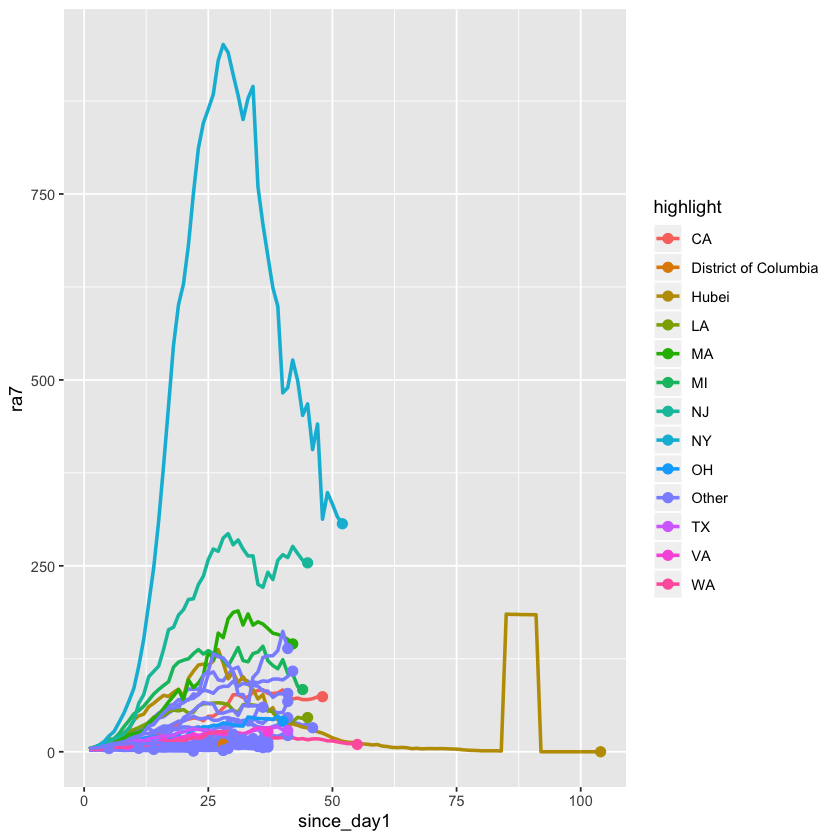

In [31]:
latest = max(data$date)
g1 <-  ggplot() + geom_line(data = data %>%filter(since_day1>0),
                            aes(x=since_day1,y=ra7,
                                group=`Province_State`,
                                colour=highlight),size=1) +
    geom_point(data=data%>%filter(date==latest,since_day1>0),aes(x=since_day1,y=ra7,
                                group=`Province_State`,
                                colour=highlight),size=2.5)

g1


Everything turned out the way we expected, except that something strange is going on with China around day 75??

Oh and we found that there's a story behind it actually: [Wuhan’s Coronavirus Death Toll Surges by 50% After China Revision](https://www.wsj.com/articles/wuhans-coronavirus-death-toll-surges-by-50-after-china-reviews-data-11587110435)

Interesting...Now we can proceed in peace.

### Aesthetics. Can't stress enough.

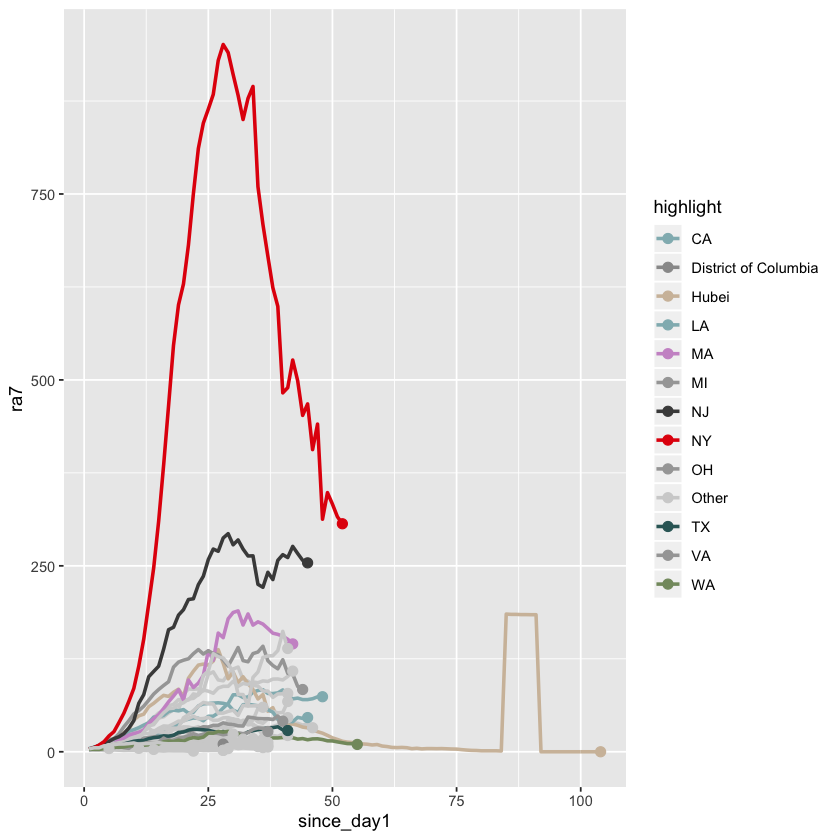

In [32]:
g2 <- g1 + scale_color_manual(values = c("#91b8bd","gray60" ,"#d1bea8",
                                          "#91b8bd","plum3","gray65",
                                          "#4a4a4a","#e3120b","gray65",
                                          "gray82","#336666","gray65",
                                         "#83986d")) 
g2

In [33]:
g2 <- g2 + geom_line(data = data %>%filter(since_day1>0,highlight!="Other"),
                            aes(x=since_day1,y=ra7,
                                group=`Province_State`,
                                colour=highlight),size=1)

### Textual annotations
Once again, the text position of China needs to be adjusted manually. Otherwise it will be cut out on the x-axis.

In [34]:
# extract the latest date from dataset
latest = max(data$date)
# extract a label for each highlighted US states
data_ = data %>% filter(`Province_State` %in% highlight_us, date==latest)

In [35]:
# adjusts the position
hubei_ <- data %>% filter(Province_State=="Hubei",date==latest-33)
# then combine
data_ %<>% rbind(hubei_)

Ready to add another layer of `geom_text()`

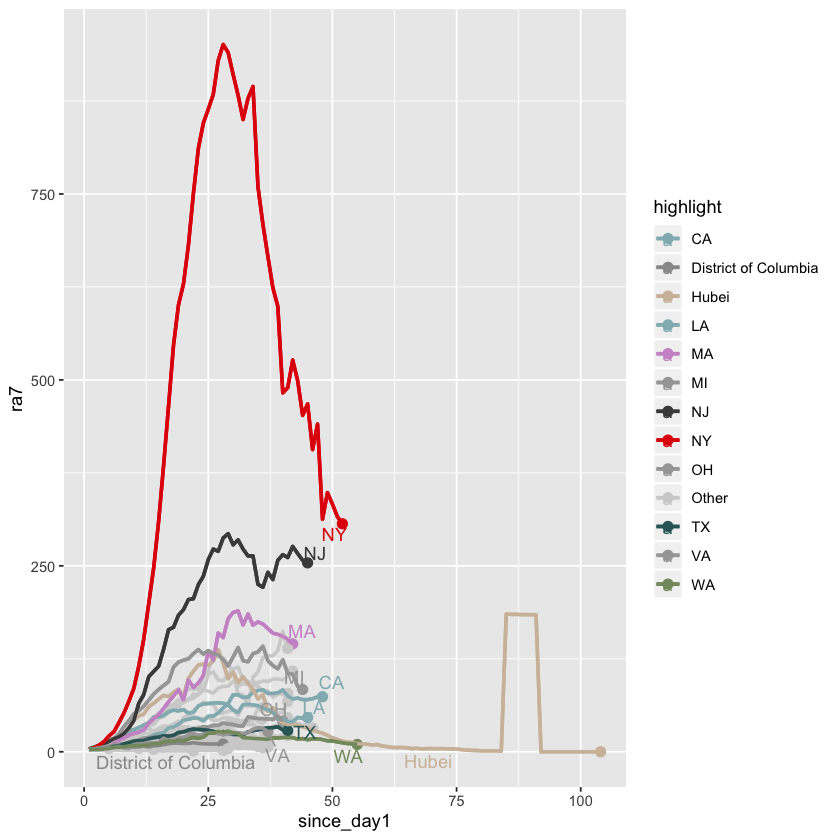

In [36]:
library(ggrepel) 
g3 <- g2  + geom_text_repel(data=data_, 
               aes(x=since_day1,
                   y=ra7,
                   group=Province_State,
                   colour=highlight,
                   label=Province_State),
                          box.padding = unit(.2, 'lines'))
g3

## Scaling the data.


Attaching package: ‘scales’


The following objects are masked from ‘package:formattable’:

    comma, percent, scientific


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 21 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_path).”


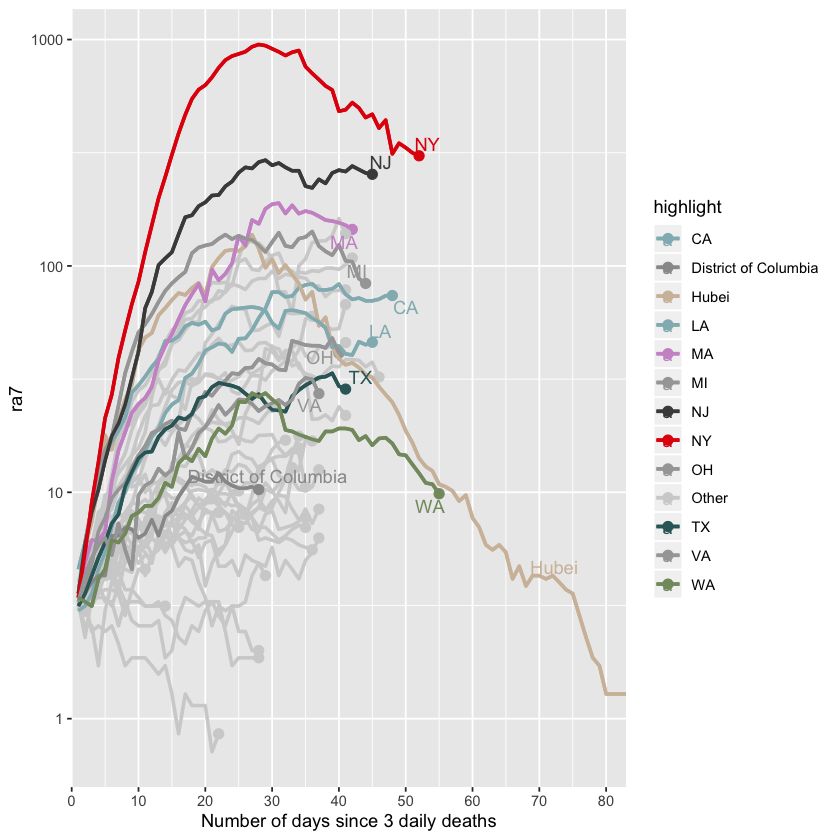

In [37]:
library(scales)
g4 <- g3 + scale_x_continuous(expand = c(0, 0),
                        limits=c(0,83),
                        breaks=seq(0,83,10), 
                        name = "Number of days since 3 daily deaths") +
    scale_y_log10()

ggdraw(g4)

# Final Touches..

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 21 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 21 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_path).”


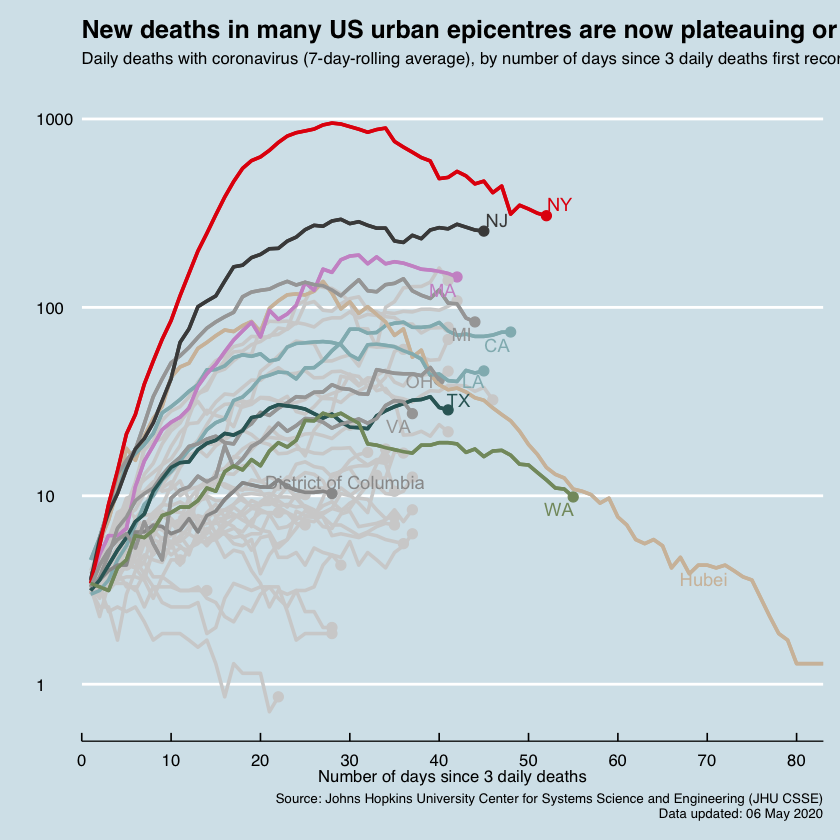

In [38]:
data_updated = Sys.Date() -1 # assuming we use the latest data every time we re-run this chunck code
title = "New deaths in many US urban epicentres are now plateauing or beginning to decline"
subtitle = "Daily deaths with coronavirus (7-day-rolling average), by number of days since 3 daily deaths first recorded\n"
caption = paste("Source: Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)\nData updated:",format(data_updated, "%d %b %Y"))
g5 <- g4 + labs(title=title,
               subtitle=subtitle,
               caption=caption,y="") + theme_economist() +theme(legend.position = "None") 

    
g5
# export to png with custom dimensions
output_label = paste0("covid_trajectory_US_",data_updated,".png")
ggsave(output_label, width = 12, height = 7, dpi = 120) 


## We are done.
# Covid trajectory tracker chart
![ourplot](covid_trajectory_US_2020-05-06.png)